DC Simulation: Blocks Model
========================

## Geoscientific Problem

Pole-dipole DC resistivity data were simulated over both a conductive and a resistive block. The background conductivity was $\sigma_0$ = 0.01 S/m. The conductor had a conductivity of $\sigma_c$ = 0.1 S/m and the resistor had a conductivity of $\sigma_r$ = 0.001 S/m. Both blocks were oriented along the Northing direction and had x, y and z dimensions of 320 m, 1200 m and 320 m. Both blocks were buried at a depth of 160 m.

DC resistivity data were simulated with a pole-dipole configuration. The survey consisted of 9 West-East survey lines, each with a length of 2000 m. The line spacing was 250 m and the electrode spacing was 100 m.

*A figure illustrating the density contrast model and survey geometry is shown further down*

## Codes/Formulations Being Compared

**SimPEG 3D Nodal Formulation:** This approach to solving the forward problem uses the *SimPEG.electromagnetics.static.simulation.Simulation3DNodal* simulation class.

**UBC-GIF DCIP OcTree:** [DCIP OcTree](https://dcipoctree.readthedocs.io/en/latest/) is a voxel cell DC/IP forward modeling and inversion package developed by the UBC Geophysical Inversion Facility. This software is proprietary and can ONLY be acquired through appropriate [commerical](https://gif.eos.ubc.ca/software/licenses_commercial) licenses. The numerical approach of the forward simulation is described in the [online manual's theory section](https://dcipoctree.readthedocs.io/en/latest/content/theory.html). If you have a valid license, there are instructions for reproducing the results (add link).

## Loading Assets Into the SimPEG Framework

We start by importing any necessary packages for running the notebook.

In [1]:
from SimPEG.electromagnetics.static import resistivity as dc
from SimPEG.electromagnetics.static.utils.static_utils import plot_3d_pseudosection, apparent_resistivity
from SimPEG.utils.io_utils import read_dcipoctree_ubc, write_dcipoctree_ubc
from discretize import TreeMesh
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly
import numpy as np

mpl.rcParams.update({"font.size": 14})

Next we download the mesh, model and simulated data for each code/formulation.

In [2]:
# For each package, download .tar files

The mesh, model and predicted data for each code are then loaded into the SimPEG framework for plotting.

In [3]:
rootdir = './../../../assets/dcip/block_model_dc_fwd_simpeg_octree/'
mesh_simpeg = TreeMesh.readUBC(rootdir+'octree_mesh.txt')
model_simpeg = TreeMesh.readModelUBC(mesh_simpeg, rootdir+'model.con')
data_simpeg = read_dcipoctree_ubc(rootdir+'dpred_simpeg.txt', 'volt')

rootdir = './../../../assets/dcip/block_model_dc_fwd_dcipoctree/'
mesh_ubc = TreeMesh.readUBC(rootdir+'octree_mesh.txt')
model_ubc = TreeMesh.readModelUBC(mesh_simpeg, rootdir+'model.con')
data_ubc = read_dcipoctree_ubc(rootdir+'data_dc.txt', 'volt')

## Plot Geophysical Scenario

Below, we plot the conductivity model and survey geometry for the forward simulation.

Text(0.5, 1.0, 'Survey Geometry')

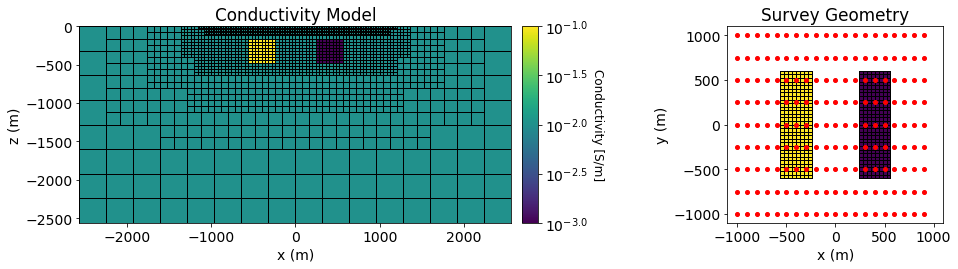

In [4]:
vmin = np.log10(model_simpeg.min())
vmax = np.log10(model_simpeg.max())
ind = int(len(mesh_simpeg.hy)/2)

fig = plt.figure(figsize=(15, 3.5))

ax1 = fig.add_axes([0.1, 0.12, 0.4, 0.78])
mesh_simpeg.plot_slice(
    np.log10(model_simpeg), ax=ax1, normal='Y', grid=True,
    ind=ind, clim=(vmin, vmax), pcolorOpts={"cmap": "viridis"},
)
ax1.set_title("Conductivity Model")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.51, 0.12, 0.015, 0.78])
norm = mpl.colors.Normalize(
    vmin=vmin, vmax=vmax
)
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, cmap=mpl.cm.viridis, orientation="vertical", format="$10^{%.1f}$"
)
cbar.set_label("Conductivity [S/m]", rotation=270, labelpad=15, size=12)

ax3 = fig.add_axes([0.7, 0.12, 0.2, 0.78])
ind = int(len(mesh_simpeg.hz)-10)
masked_model = np.log10(model_simpeg)
masked_model[masked_model==-2]=np.NaN
mesh_simpeg.plot_slice(
    masked_model, ax=ax3, normal='Z', grid=True,
    ind=ind, clim=(vmin, vmax), pcolorOpts={"cmap": "viridis"},
)
for ii in range(0, 9):
    ax3.plot(np.arange(-1000, 1000, 100), -1000+ii*250*np.ones(20), 'ro', markersize=4)
ax3.set_xlim([-1100, 1100])
ax3.set_ylim([-1100, 1100])
ax3.set_xlabel('x (m)')
ax3.set_ylabel('y (m)')
ax3.set_title('Survey Geometry')

## Comparing Simulated Voltage Data

Here we plot the simulated data for all codes.

In [5]:
mpl.rcParams.update({'font.size': 16})

plane_points = []
for x in np.arange(-1000, 1100, 500):
    p1, p2, p3 = np.array([-1000.,x,0]), np.array([1000,x,0]), np.array([1000,x,-1000])
    plane_points.append([p1,p2,p3])

scene = dict(
    xaxis=dict(range=[-1000, 1000]),
    yaxis=dict(range=[-1000, 1000]),
    zaxis=dict(range=[-500, 0]),
    aspectratio=dict(x=1, y=1, z=0.5)
)
scene_camera=dict(
    center=dict(x=-0.1, y=0, z=-0.2), eye=dict(x=1.2, y=-1, z=1.5)
)
vlim = [data_ubc.dobs.min(), data_ubc.dobs.max()]
fig1 = plot_3d_pseudosection(
    data_ubc.survey, data_ubc.dobs, scale='log', vlim=vlim,
    plane_points=plane_points, plane_distance=10., units='V'
)

fig1.update_layout(
    title_text="Voltage Data (UBC)", title_x=0.5,
    scene_camera=scene_camera, scene=scene, width=600, height=550
)
plotly.io.show(fig1)

vlim = [data_simpeg.dobs.min(), data_simpeg.dobs.max()]
fig2 = plot_3d_pseudosection(
    data_simpeg.survey, data_simpeg.dobs, marker_size=150, scale='log', vlim=vlim,
    plane_points=plane_points, plane_distance=10., units='V'
)
fig2.update_layout(
    title_text="Voltage Data (SimPEG)", title_x=0.5,
    scene_camera=scene_camera, scene=scene, width=600, height=550
)
plotly.io.show(fig2)

## Plot Data as Apparent Conductivities

In [6]:
mpl.rcParams.update({'font.size': 16})

plane_points = []
for x in np.arange(-1000, 1100, 500):
    p1, p2, p3 = np.array([-1000.,x,0]), np.array([1000,x,0]), np.array([1000,x,-1000])
    plane_points.append([p1,p2,p3])

scene_camera=dict(
    center=dict(x=-0.1, y=0, z=-0.2), eye=dict(x=1.2, y=-1, z=1.5)
)
scene = dict(
    xaxis=dict(range=[-1000, 1000]),
    yaxis=dict(range=[-1000, 1000]),
    zaxis=dict(range=[-500, 0]),
    aspectratio=dict(x=1, y=1, z=0.5)
)

app_cond_ubc = 1./apparent_resistivity(
    data_ubc, space_type="half space", dobs=data_ubc.dobs, eps=1e-10,
)
vlim = [app_cond_ubc.min(), app_cond_ubc.max()]
fig1 = plot_3d_pseudosection(
    data_ubc.survey, app_cond_ubc, scale='log', vlim=vlim,
    plane_points=plane_points, plane_distance=10., units='S/m'
)
fig1.update_layout(
    title_text="Apparent Conductivities (UBC)", title_x=0.5,
    width=600, height=550, scene_camera=scene_camera, scene=scene
)
plotly.io.show(fig1)

app_cond_simpeg = 1./apparent_resistivity(
    data_simpeg, space_type="half space", dobs=data_simpeg.dobs, eps=1e-10,
)
vlim = [app_cond_simpeg.min(), app_cond_simpeg.max()]
fig2 = plot_3d_pseudosection(
    data_simpeg.survey, app_cond_simpeg, scale='log', vlim=vlim,
    plane_points=plane_points, plane_distance=10., units='S/m'
)

fig2.update_layout(
    title_text="Apparent Conductivities (SimPEG)", title_x=0.5,
    width=600, height=550, scene_camera=scene_camera, scene=scene
)
plotly.io.show(fig2)

## Plot Error

In [7]:
err = 100*(data_simpeg.dobs - data_ubc.dobs)/data_simpeg.dobs

vlim = [err.min(), err.max()]
fig = plot_3d_pseudosection(
    data_simpeg.survey, err, scale='linear', vlim=vlim,
    plane_points=plane_points, plane_distance=10., units='%'
)
fig.update_layout(
    title_text="% Error", title_x=0.5, width=600, height=550, scene_camera=scene_camera, scene=scene
)
plotly.io.show(fig)

print('Min % error:', np.min(np.abs(err)))
print('Max % error:', np.max(np.abs(err)))
print('Average % error:', np.mean(np.abs(err)))
print('Median % error:', np.median(np.abs(err)))

Min % error: 0.000531333091966312
Max % error: 2.4171452528043
Average % error: 0.7768734200076275
Median % error: 0.6571610665758801
